# Notebook used for final analysis


## Forward Euler, using C0 from analytical solution

In [1]:
import numpy as np
import functions as f
import matplotlib.pyplot as plt

In [10]:
save_fig = False

In [2]:
Nt_gaps = 10000    # number of timesteps
T = 60             # final time 

Nx_spaces = 1000;   # number of spaces in x
L1 = -10; # Distance behind 0 reference point
L2 = 25 # Distance in front  0 reference point
C0 = 8.713e-3
D = 0.1
heart_loc = 12.5

In [4]:
Cf, U, x, t = f.forward_euler(Nt_gaps, Nx_spaces, L1, L2, C0=C0, T=60, D=D, v=0.2, b0=0, bL=0, x_heart=heart_loc)

Cf

0.0010154340876849866

Plot and export images for report

Time = 0

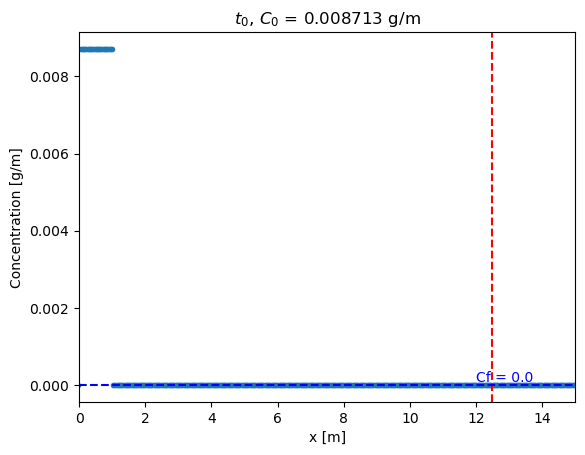

In [6]:
fig, ax = plt.subplots()
f.concentration_x_plot(x, U[:,0], C0, heart_loc, t_str='$t_{0}$', ax=ax)

if save_fig:
    plt.savefig("images/concetration_t0.eps", format="eps")

Time = end

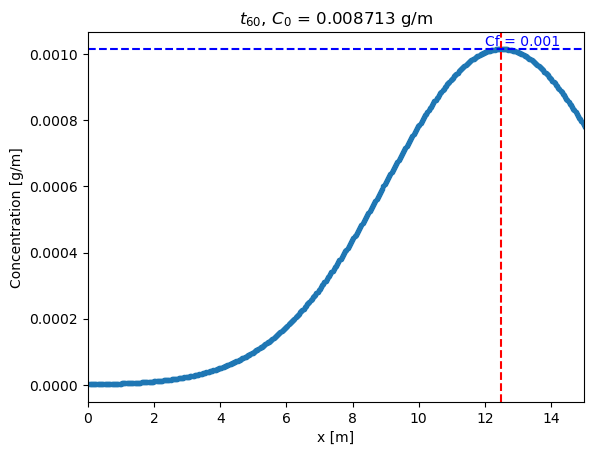

In [7]:
fig, ax = plt.subplots()
f.concentration_x_plot(x, U[:,-1], C0, heart_loc, t_str='$t_{60}$', ax=ax)

if save_fig:
    plt.savefig("images/concetration_t_end.eps", format="eps")

Plot many Time locations

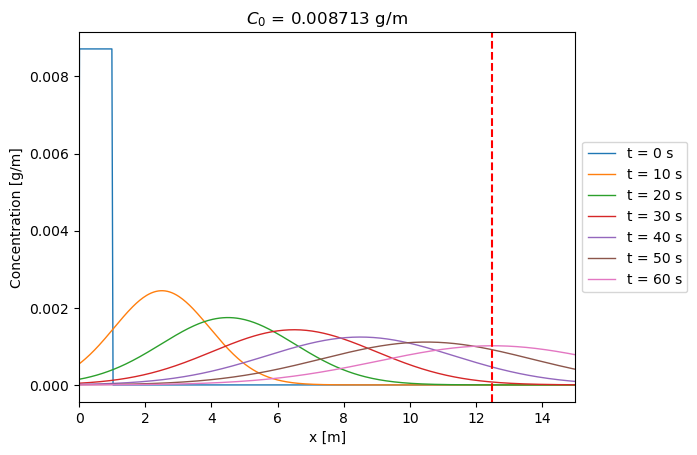

<Figure size 640x480 with 0 Axes>

In [8]:
delta_t = 10
t_to_plot = np.arange(0, 60 + delta_t, delta_t)

heart_loc = 12.5
index_closest = (np.abs(x - heart_loc)).argmin()
C_heart = U[index_closest,-1]


fig, ax = plt.subplots()
for tt in t_to_plot:
    index_closest = (np.abs(t - tt)).argmin()
    ax.plot(x, U[:, index_closest], '-', linewidth = 1, label=f't = {tt} s')
    
    # if tt == 60:
    #     ax.axhline(y=C_heart, color='b', linestyle='--', label= f'Cf = {round(C_heart, 4)}')
    #     ax.text(x=12, y=C_heart, s=f'Cf = {round(C_heart, 4)}', color='b', va='bottom', ha='left')
    
ax.set_xlabel('x [m]')
ax.set_ylabel('Concentration [g/m]')
ax.set_xlim([0,15])

# ax.legend() 
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.axvline(x=heart_loc, color='r', linestyle='--')

title_str = f'$C_0$ = {C0} g/m'
ax.set_title(title_str)

plt.show()

if save_fig:
    plt.savefig("images/concentration_over_time.eps", format="eps")

# Backward Euler

In [ ]:
# Run Backward Euler:




Cf_desired = 1e-3

Cf_backwards, U_backwards, x_backwards, t_backwards = f.backward_euler(Nt_gaps, Nx_spaces, L1, L2, C0, T=60, D=D, v=v, b0=0, bL=0, x_heart=heart_loc)

diff = abs(Cf - Cf_desired)


print(f'Cf = {Cf_backwards}')

print(f'Difference between Cf and desired Cf: {diff}')




# Non Constant Blood Flow

Using our piecewise function

In [42]:
# D = 0.1 # Diffusion coefficient
D = 6.7e-10 # Diffusion coefficient

# v_mean = 0.2 # Blood flow rate

Cf_desired = 1e-3 # Desired final concentrations

In [61]:
# Time parameters
Nt_gaps = 10000    # number of timesteps
T = 60             # final time 
Nt_points = Nt_gaps + 1
t = np.linspace(0.,T,Nt_points)  # times at each time step
dt = t[1] - t[0]


# x parameters
Nx_spaces = 1000;   # number of spaces in x
L1 = -15; # Distance behind 0 reference point
L2 = 25 # Distance in front  0 reference point
Nx_points = Nx_spaces + 1 
x = np.linspace(L1, L2, Nx_points)    # mesh points in space
dx = x[1] - x[0]

# Check our conditions
C = D*dt/(dx**2)
# A = v_mean*dt/(2*dx)

# print(f"Delta x = {round(dx, 4)}\nDelta t = {round(dt, 4)}\nC = {round(C, 4)}\nA = {round(A, 4)}")


# if C >= 0.5:
#     warnings.warn(f'C is greater than 0.5, C = {round(C,4)}')

# if A > 1:
#     warnings.warn(f'A is greater than 1, A = {round(A,4)}')

# Boundary conditions
# dirichlet
b0 = 0
bL = 0

In [ ]:
def v_t(t):
    # Making our velocity term based off of the piecewise function
    v = np.zeros_like(t)
    v[t < 59.82] = 0.1
    v[t >= 59.82] = 0.38
    
    return v

In [63]:
def I(x, C0): # initial u(x,0)
    u = np.zeros_like(x)
    
    # where x is between 0 and 1, set to C0
    u[(x >= 0) & (x <= 0.5)] = C0
    return u

# Initial concentration
# C0 = 1e-2
C0 = 8.713e-3

In [64]:
def get_A(v, dt, dx):
    A = v*dt/(2*dx)
    return A

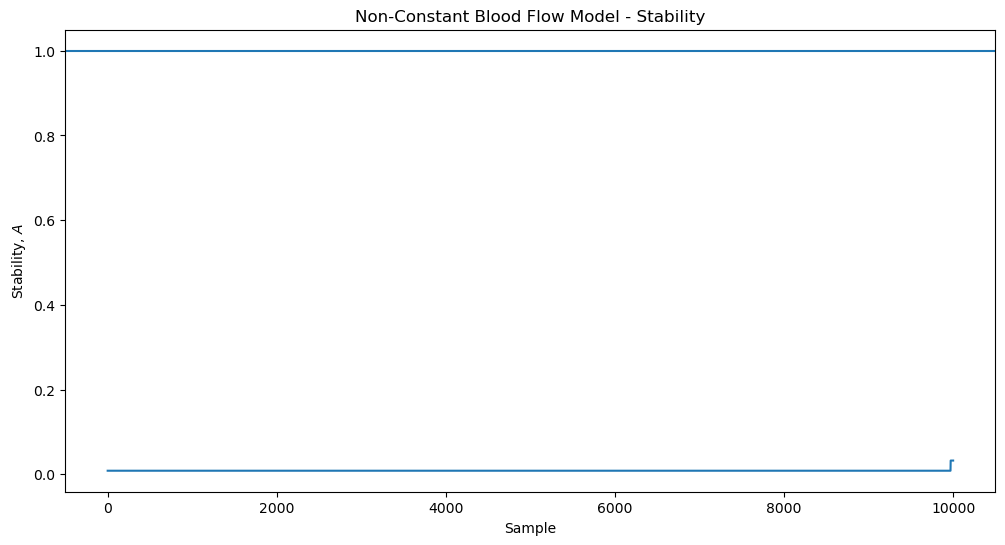

In [58]:
A_all = v*dt/(2*dx)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(A_all)
ax.axhline(1)


ax.set_xlabel('Sample')
ax.set_ylabel('Stability, $A$')

ax.set_title('Non-Constant Blood Flow Model - Stability')

plt.show()


In [65]:
# # Solve
v = v_t(t)

# Define the numerical solution 
# the first index is space and the second time
U = np.zeros((Nx_points, Nt_points))

# The initial condition
U[:,0] = I(x, C0)

# Enforce the boundary condition
U[0,0]  = b0 
U[-1,0] = bL

# Old/current values
u_old = I(x, C0)

# Initialize new matrix
u = np.zeros(Nx_points)

for n in range(1, Nt_points):
    u[0] = b0
    u[-1] = bL
    
    A_t = get_A(v[n], dt, dx)
    
    # apply forward Euler on the internal points, diffusion and advection
    for i in range(1, Nx_points-1):
        u[i] = u_old[i] + C *(u_old[i-1] - 2*u_old[i] + u_old[i+1]) - A_t*(u_old[i+1] - u_old[i-1])

    # update u_old before next step
    u_old[:] = u
    
    # copy into full storage
    U[:,n] = u;

In [66]:
heart_loc = 5.982 + 0.07 + 0.5
index_closest = (np.abs(x - heart_loc)).argmin()
C_heart = U[index_closest,-1]
C_heart

0.002582923754400532

In [67]:
U.shape

(1001, 10001)

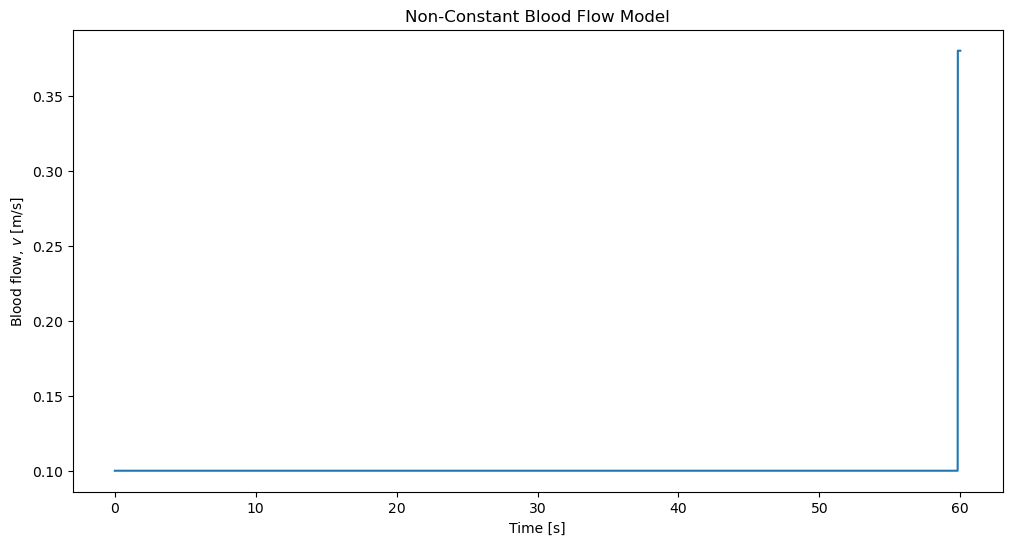

In [68]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(t, v)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Blood flow, $v$ [m/s]')

ax.set_title('Non-Constant Blood Flow Model')

plt.show()

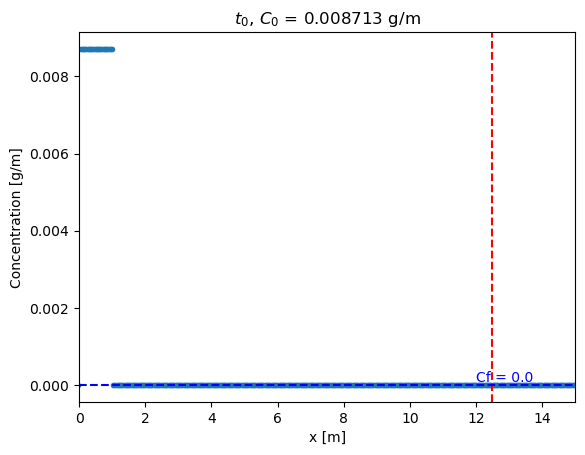

In [9]:
fig, ax = plt.subplots()
f.concentration_x_plot(x, U[:,0], C0, heart_loc, t_str='$t_{0}$', ax=ax)

if save_fig:
    plt.savefig("images/concetration_t0_non_constant.eps", format="eps")

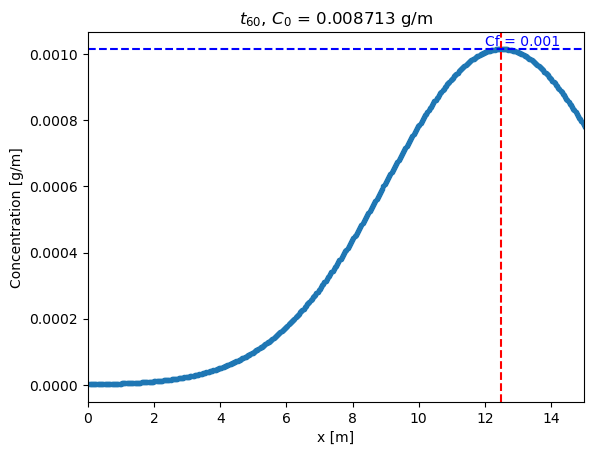

In [11]:
fig, ax = plt.subplots()
f.concentration_x_plot(x, U[:,-1], C0, heart_loc, t_str='$t_{60}$', ax=ax)

if save_fig:
    plt.savefig("images/concetration_t_end_non_constant.eps", format="eps")